In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, init, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
all_features = pd.concat((train_data.loc[:, 'MSSubClass':'SaleCondition'],
                          test_data.loc[:, 'MSSubClass':'SaleCondition']))

G:\anaconda\lib\site-packages\requests\packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


训练数据集 1460个样本 80个特征 1个标签

测试数据集 1459个样本 80个特征

In [2]:
train_data.shape

(1460, 81)

In [3]:
test_data.shape

(1459, 80)

In [4]:
# 数字的特征 将所有不是文字的特征取出来
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index
# 将所有数字特征进行标准化 我们对连续数值的特征做标准化处理。
# 如果一个特征的值是连续的，设该特征在训练数据集和测试数据集上的均值为μ，标准差为σ。那么，该特征的每个值将先减去μ再除以σ。
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

In [5]:
# 处理文本特征 虚拟变量
all_features = pd.get_dummies(all_features, dummy_na=True)
# 对缺失数据用平均值填充
all_features = all_features.fillna(all_features.mean())

In [6]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].as_matrix()
test_features = all_features[n_train:].as_matrix()
train_labels = train_data.SalePrice.as_matrix()

In [7]:
train_features = nd.array(train_features)
train_labels = nd.array(train_labels)
train_labels.reshape((n_train, 1))
test_features = nd.array(test_features)

In [8]:
loss = gloss.L2Loss()
def get_rmse_log(net, train_features, train_labels):
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    return nd.sqrt(2 * loss(clipped_preds.log(),
                            train_labels.log()).mean()).asnumpy()

In [104]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(100,activation='relu'))
    net.add(nn.Dropout(0.1))
    net.add(nn.Dense(1))
    net.initialize(init=init.Xavier())
    return net

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, verbose_epoch, learning_rate, weight_decay, batch_size):
    train_ls = []
    if test_features is not None:
        test_ls = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了 Adam 优化算法。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    net.initialize(init=init.Xavier())
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
            cur_train_l = get_rmse_log(net, train_features, train_labels)
        if epoch >= verbose_epoch:
            print("epoch %d, train loss: %f" % (epoch, cur_train_l))
        train_ls.append(cur_train_l)
        if test_features is not None:
            cur_test_l = get_rmse_log(net, test_features, test_labels)
            test_ls.append(cur_test_l)
    if test_features is not None:
        gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                    range(1, num_epochs+1), test_ls, ['train', 'test'])
    else:
        gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss')
    if test_features is not None:
        return cur_train_l, cur_test_l
    else:
        return cur_train_l

In [14]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay, batch_size):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_l_sum = 0.0
    test_l_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]
        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_l, test_l = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay, batch_size)
        train_l_sum += train_l
        print("test loss: %f" % test_l)
        test_l_sum += test_l
    return train_l_sum / k, test_l_sum / k

G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense493_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense494_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


epoch 98, train loss: 0.088046
epoch 99, train loss: 0.088467
epoch 100, train loss: 0.088504


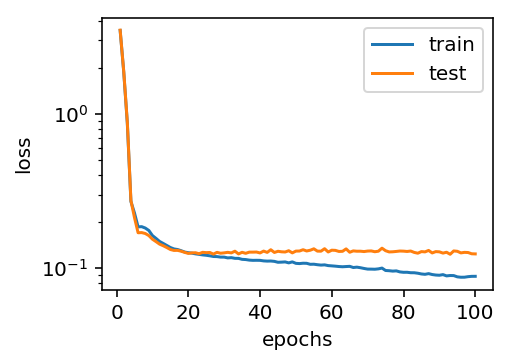

test loss: 0.123675


G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense495_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense496_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


epoch 98, train loss: 0.078803
epoch 99, train loss: 0.082425
epoch 100, train loss: 0.078035


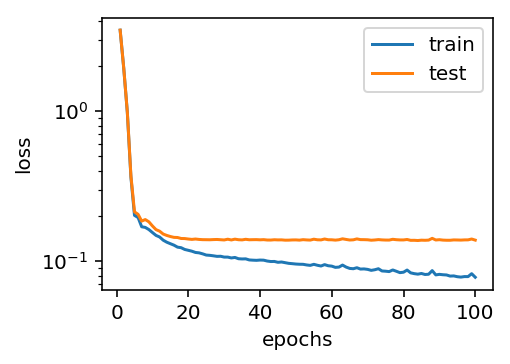

test loss: 0.138003


G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense497_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense498_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


epoch 98, train loss: 0.085747
epoch 99, train loss: 0.085040
epoch 100, train loss: 0.084949


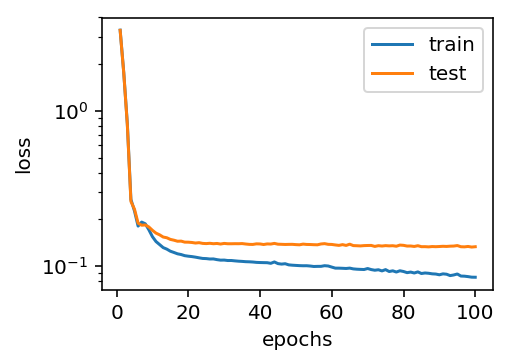

test loss: 0.133556
3-fold validation: avg train loss: 0.083829, avg test loss: 0.131745


In [108]:
k = 3
num_epochs = 100
verbose_epoch = num_epochs-2
lr = 0.1
weight_decay = 85
batch_size = 64

train_l, test_l = k_fold_cross_valid(k, num_epochs, verbose_epoch,
                                     train_features, train_labels, lr,
                                     weight_decay, batch_size)
print("%d-fold validation: avg train loss: %f, avg test loss: %f"
      % (k, train_l, test_l))

In [88]:
def train_and_pred(num_epochs, verbose_epoch, train_features, test_feature,
                   train_labels, test_data, lr, weight_decay, batch_size):
    net = get_net()
    train(net, train_features, train_labels, None, None, num_epochs,
          verbose_epoch, lr, weight_decay, batch_size)
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense499_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
G:\anaconda\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter dense500_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


epoch 98, train loss: 0.080492
epoch 99, train loss: 0.080581
epoch 100, train loss: 0.082727


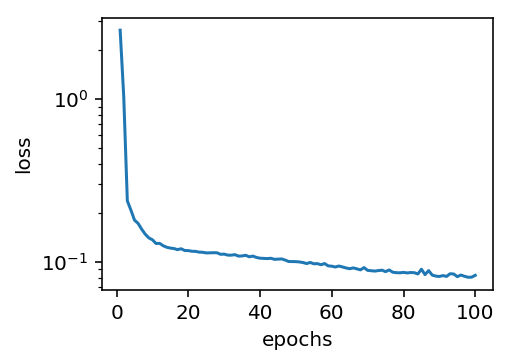

In [109]:
train_and_pred(num_epochs, verbose_epoch, train_features, test_features,
               train_labels, test_data, lr, weight_decay, batch_size)